# Detección de Anomalías en Variables de un Ingenio Azucarero

Este notebook muestra cómo detectar anomalías en variables críticas de proceso (como el Brix, temperatura, presión y porcentaje de extracción) utilizando métodos estadísticos y el algoritmo **Isolation Forest**. También se construye un score de anomalía ponderado multivariable para evaluar el comportamiento general del sistema.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Simulación de datos
np.random.seed(42)
n = 300
time = pd.date_range(start="2025-01-01", periods=n, freq="h")

brix = np.random.normal(loc=12, scale=0.5, size=n)
temp_jugo = np.random.normal(loc=85, scale=2, size=n)
presion = np.random.normal(loc=25, scale=1.5, size=n)
extraccion = np.random.normal(loc=95, scale=1, size=n)

In [3]:
# Simulación de Anomalías
anomalies_idx = np.random.choice(n, size=15, replace=False)
brix[anomalies_idx[:5]] += np.random.normal(loc=4, scale=1, size=5)
temp_jugo[anomalies_idx[5:10]] += np.random.normal(loc=10, scale=2, size=5)
presion[anomalies_idx[10:]] -= np.random.normal(loc=5, scale=1, size=5)

In [4]:
# Dataframe
df = pd.DataFrame({
    'timestamp': time,
    'brix': brix,
    'temp_jugo': temp_jugo,
    'presion': presion,
    'extraccion': extraccion
})

## Detección Multivariable con Isolation Forest y Score Ponderado

Se aplican modelos `IsolationForest` para cada variable por separado, se identifican las anomalías y se construye un **score ponderado** que representa una medida compuesta de anomalía.

In [5]:
# Función de score ponderado por variable
def weighted_anomaly_score(data, weights):
    scores = {}
    anomaly_flags = {}
    for var in weights:
        iso = IsolationForest(contamination=0.05, random_state=42)
        score = -iso.fit(data[[var]]).decision_function(data[[var]])
        flag = iso.predict(data[[var]]) == -1
        scores[var] = score * weights[var]
        anomaly_flags[f'{var}_is_anomaly'] = flag
    score_df = pd.DataFrame(scores)
    flag_df = pd.DataFrame(anomaly_flags)
    return score_df.sum(axis=1), flag_df

In [6]:
# Pesos y cálculo
pesos = {'brix': 0.4, 'temp_jugo': 0.2, 'presion': 0.3, 'extraccion': 0.1}
df['weighted_score'], anomaly_flags = weighted_anomaly_score(df, pesos)
df = pd.concat([df, anomaly_flags], axis=1)

In [7]:
# Umbral
threshold = df['weighted_score'].mean() + 2*df['weighted_score'].std()
df['strong_anomaly'] = df['weighted_score'] > threshold

## Visualización de Anomalías por Variable

A continuación se muestran gráficos individuales para cada variable del proceso, resaltando las observaciones que fueron clasificadas como anómalas.

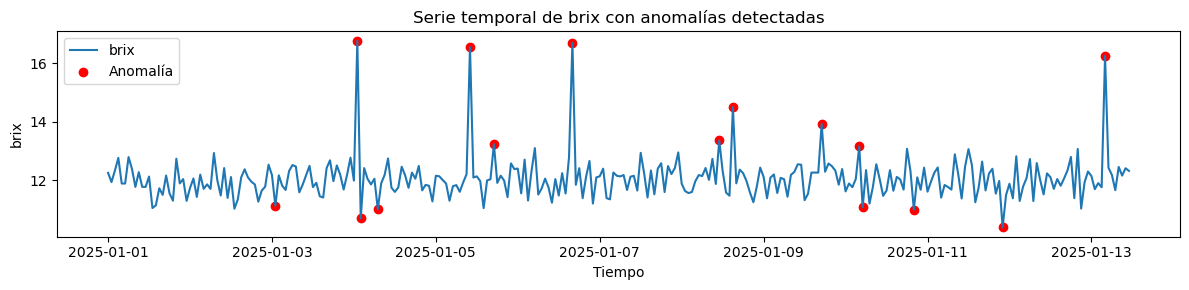

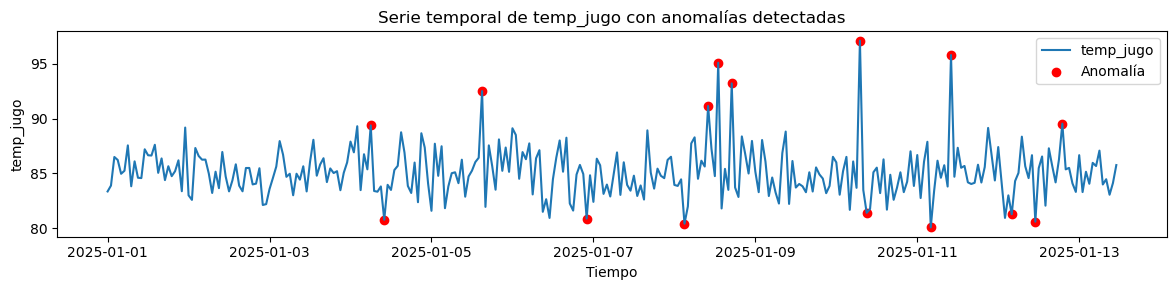

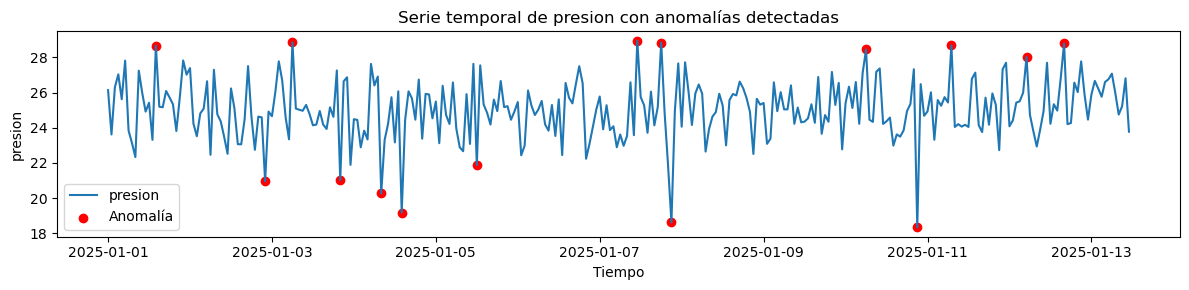

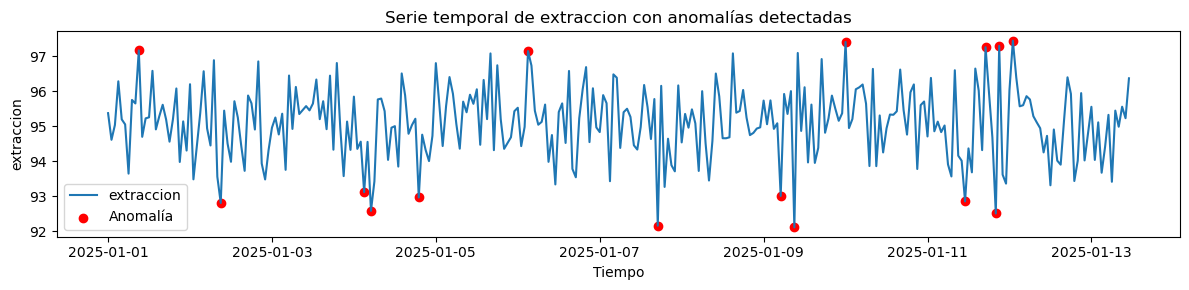

In [8]:
# 1. Gráficos individuales por variable con sus anomalías
variables = ['brix', 'temp_jugo', 'presion', 'extraccion']
for var in variables:
    plt.figure(figsize=(12, 3))
    plt.plot(df['timestamp'], df[var], label=var)
    plt.scatter(df[df[f'{var}_is_anomaly']]['timestamp'], df[df[f'{var}_is_anomaly']][var],
                color='red', label='Anomalía')
    plt.title(f'Serie temporal de {var} con anomalías detectadas')
    plt.xlabel('Tiempo')
    plt.ylabel(var)
    plt.legend()
    plt.tight_layout()
    plt.show()

## Score Total Ponderado y Umbral de Anomalías Fuertes

Se grafica el score de anomalía combinado de todas las variables, junto con un umbral estadístico para identificar anomalías críticas.

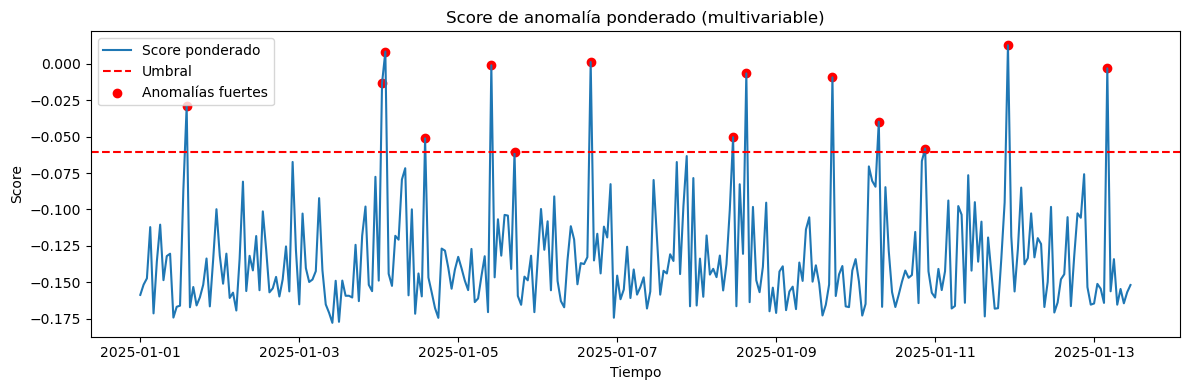

In [9]:
# 2. Score total con anomalías fuertes
plt.figure(figsize=(12, 4))
plt.plot(df['timestamp'], df['weighted_score'], label='Score ponderado')
plt.axhline(threshold, color='red', linestyle='--', label='Umbral')
plt.scatter(df[df['strong_anomaly']]['timestamp'],
            df[df['strong_anomaly']]['weighted_score'],
            color='red', label='Anomalías fuertes')
plt.title('Score de anomalía ponderado (multivariable)')
plt.xlabel('Tiempo')
plt.ylabel('Score')
plt.legend()
plt.tight_layout()
plt.show()

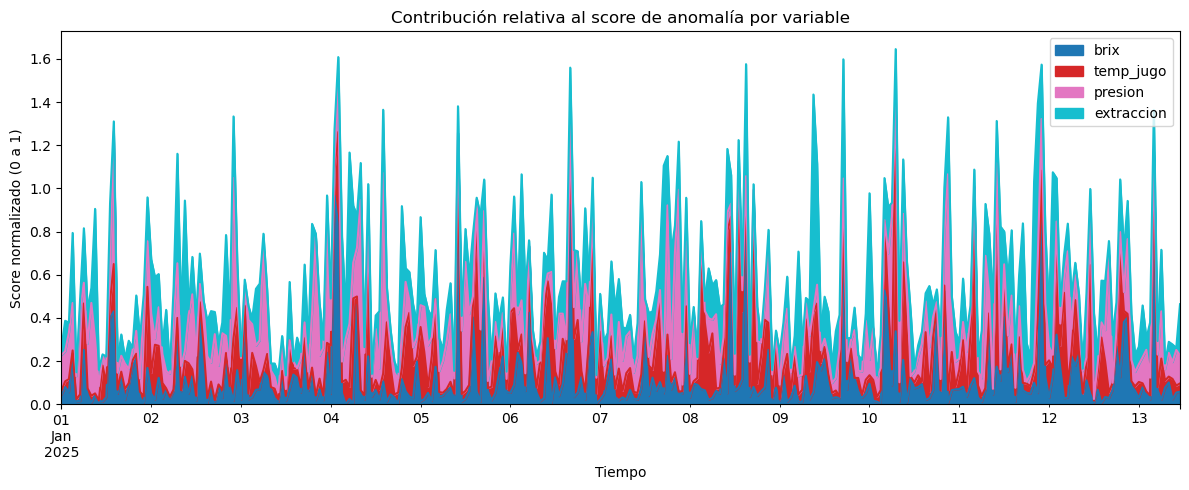

In [10]:
# Calcular scores sin ponderar
def raw_variable_scores(data):
    scores = {}
    for var in variables:
        iso = IsolationForest(contamination=0.05, random_state=42)
        score = -iso.fit(data[[var]]).decision_function(data[[var]])
        scores[var] = score
    return pd.DataFrame(scores)

raw_scores = raw_variable_scores(df)

# Escalar entre 0 y 1 para evitar valores negativos en gráficos de área
scaler = MinMaxScaler()
raw_scores_scaled = pd.DataFrame(scaler.fit_transform(raw_scores), columns=variables)
raw_scores_scaled['timestamp'] = df['timestamp']

# Graficar área apilada
raw_scores_scaled.set_index('timestamp').plot.area(stacked=True, figsize=(12, 5), cmap='tab10')
plt.title('Contribución relativa al score de anomalía por variable')
plt.ylabel('Score normalizado (0 a 1)')
plt.xlabel('Tiempo')
plt.tight_layout()
plt.show()

## Heatmap por Hora y Día

El siguiente heatmap permite visualizar la intensidad del score de anomalía a lo largo del tiempo, agrupado por día y hora. Esto ayuda a identificar patrones anómalos en la operación.

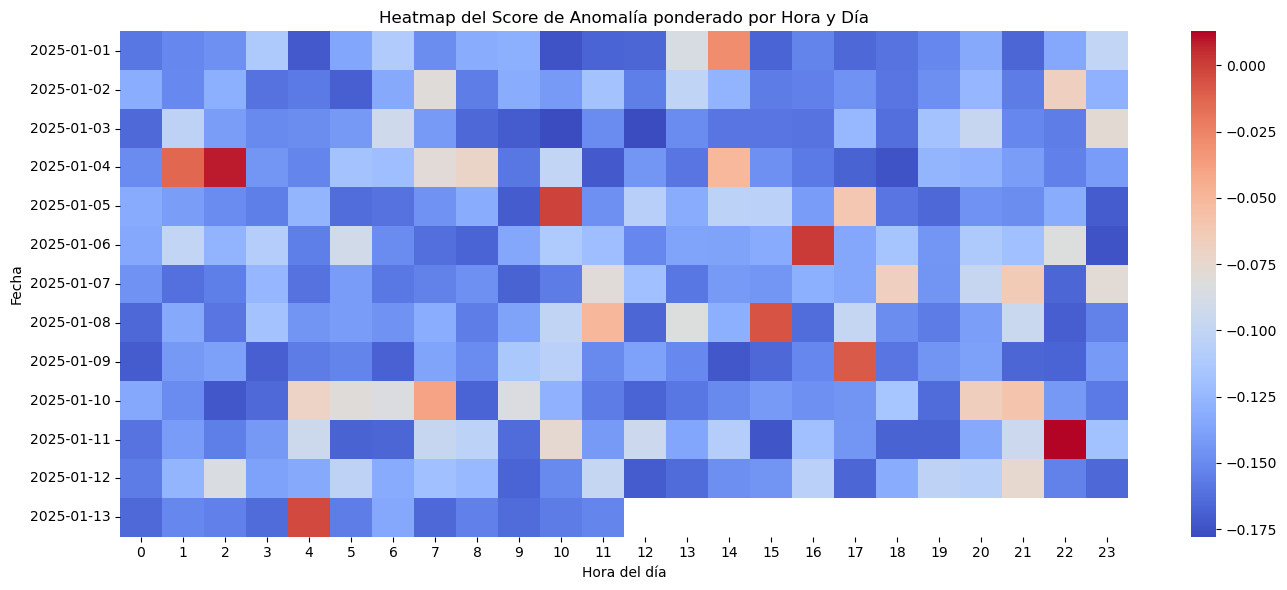

In [11]:
# 3. Heatmap del score por hora y día
df['hour'] = df['timestamp'].dt.hour
df['day'] = df['timestamp'].dt.date
pivot = df.pivot_table(index='day', columns='hour', values='weighted_score')

plt.figure(figsize=(14, 6))
sns.heatmap(pivot, cmap='coolwarm', annot=False)
plt.title('Heatmap del Score de Anomalía ponderado por Hora y Día')
plt.xlabel('Hora del día')
plt.ylabel('Fecha')
plt.tight_layout()
plt.show()

## Densidad de cada Variable y Detección de Anomalías

Aquí se analiza la distribución de cada variable y se marcan las regiones donde el modelo identifica comportamientos anómalos.

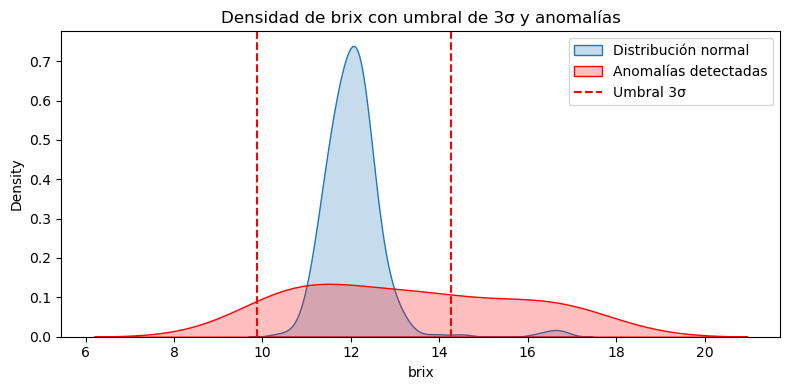

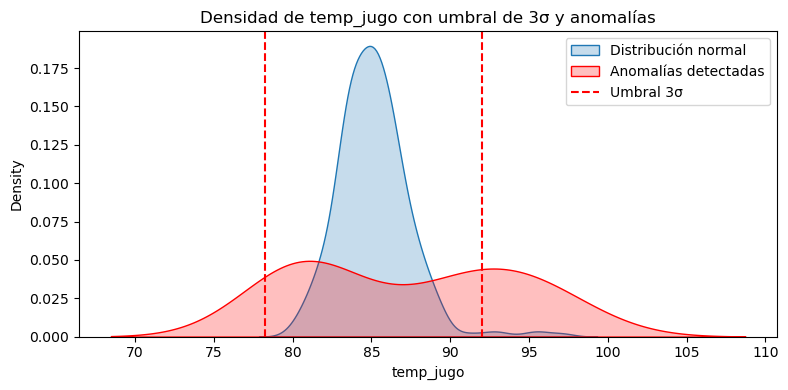

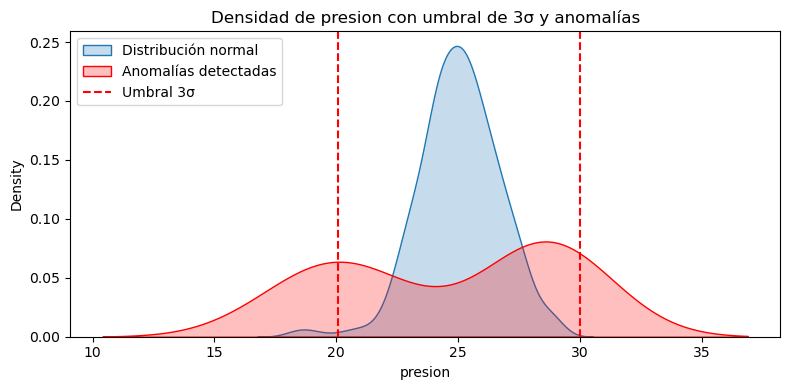

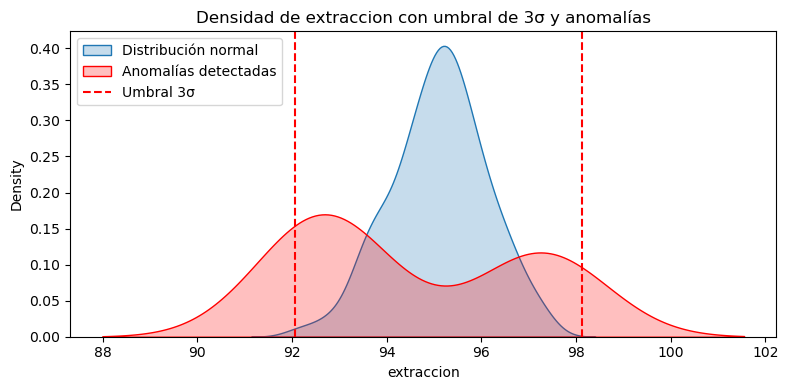

In [12]:
# 4. Gráficos de densidad para cada variable, marcando umbrales generales

for var in variables:
    plt.figure(figsize=(8, 4))
    sns.kdeplot(df[var], fill=True, label='Distribución normal')
    sns.kdeplot(df[df[f'{var}_is_anomaly']][var], color='red', fill=True, label='Anomalías detectadas')
    plt.axvline(df[var].mean() + 3*df[var].std(), color='red', linestyle='--', label='Umbral 3σ')
    plt.axvline(df[var].mean() - 3*df[var].std(), color='red', linestyle='--')
    plt.title(f'Densidad de {var} con umbral de 3σ y anomalías')
    plt.xlabel(var)
    plt.legend()
    plt.tight_layout()
    plt.show()

### Correlaciones Normales vrs. Correlaciones en Condiciones Anómalas

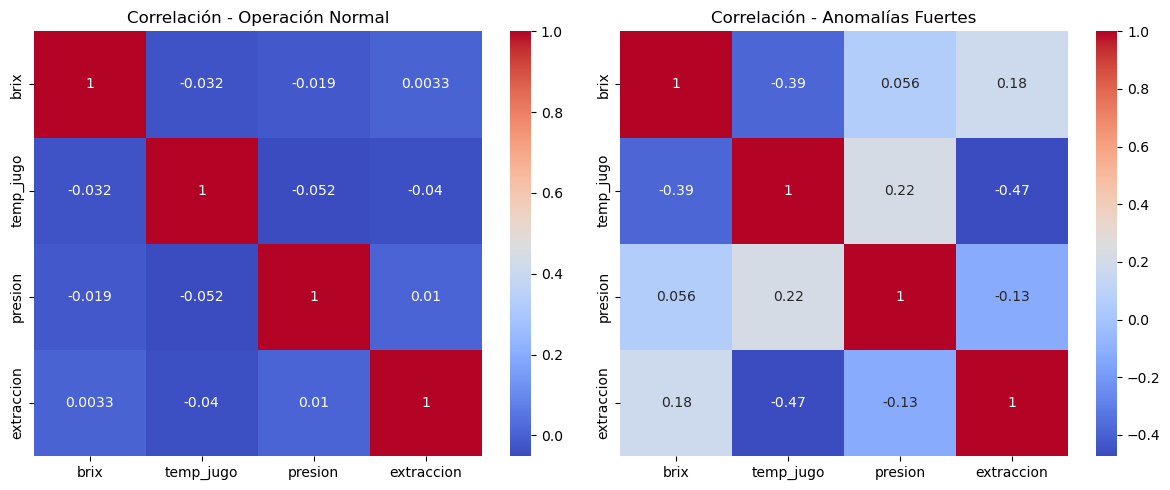

In [13]:
# Correlaciones normales vs. en anomalías fuertes
normal_corr = df[~df['strong_anomaly']][variables].corr()
anomaly_corr = df[df['strong_anomaly']][variables].corr()

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(normal_corr, annot=True, cmap='coolwarm', ax=axs[0])
axs[0].set_title('Correlación - Operación Normal')

sns.heatmap(anomaly_corr, annot=True, cmap='coolwarm', ax=axs[1])
axs[1].set_title('Correlación - Anomalías Fuertes')
plt.tight_layout()
plt.show()

In [14]:
cols_anom = [f'{var}_is_anomaly' for var in variables]
df_anom = df[df['strong_anomaly']][['timestamp', 'weighted_score'] + cols_anom]
df_anom.head(10)

,timestamp,weighted_score,brix_is_anomaly,temp_jugo_is_anomaly,presion_is_anomaly,extraccion_is_anomaly
14,2025-01-01 14:00:00,-0.029275,False,False,True,False
73,2025-01-04 01:00:00,-0.013299,True,False,False,False
74,2025-01-04 02:00:00,0.008443,True,False,False,False
86,2025-01-04 14:00:00,-0.051174,False,False,True,False
106,2025-01-05 10:00:00,-0.001015,True,False,False,False
113,2025-01-05 17:00:00,-0.060784,True,False,False,False
136,2025-01-06 16:00:00,0.001231,True,False,False,False
179,2025-01-08 11:00:00,-0.050380,True,False,False,False
183,2025-01-08 15:00:00,-0.006589,True,False,False,False
209,2025-01-09 17:00:00,-0.009273,True,False,False,False


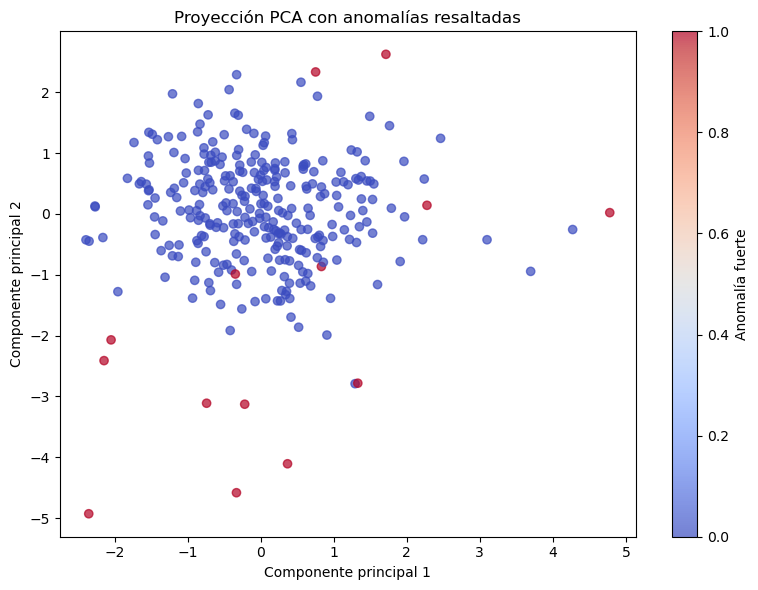

In [15]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[variables])

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['strong_anomaly'], cmap='coolwarm', alpha=0.7)
plt.title('Proyección PCA con anomalías resaltadas')
plt.xlabel('Componente principal 1')
plt.ylabel('Componente principal 2')
plt.colorbar(label='Anomalía fuerte')
plt.tight_layout()
plt.show()